# Colorectal polyp segmentation #
The code below uses the CVC-ClinicDB public data set which consists of 612 images with corresponding segmentation masks. The dataset can be found here: https://www.kaggle.com/balraj98/cvcclinicdb?select=metadata.csv.

To run the code, put the original .tif files in the `/data/images` folder and the segmentation masks (ground truth) in the `/data/masks` folder.

In [9]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from sklearn.model_selection import StratifiedKFold
# from Losses import ComboLoss, dice_metric

import albumentations as albu
from albumentations.pytorch.transforms import ToTensor

In [10]:
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

In [11]:
DATA_DIR         = Path(f'data/')
TRAIN_IMG_DIR    = DATA_DIR/'images'
TRAIN_MASK_DIR   = DATA_DIR/'masks'
RLE_DF_PATH      = 'rle.csv'
KFOLD_PATH       = 'rle_kfold.csv'
FOLD_ID          = 4
TRAIN_BATCH_SIZE = 14
VALID_BATCH_SIZE = 14
USE_SAMPLER      = False

In [12]:
# The public datasets have more than 2 colors (due to gradients around the edges). Convert those colors to either black or white
def map_binary(mask):
    (threshold, black_and_white) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return black_and_white

In [13]:
# Run-length encode the segmentation masks
def rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle


def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [14]:
def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

Convert segmentation masks to RLE (https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0), put them in a dataframe and write to a CSV. This will create a dataframe that looks like this:

| ImageId | EncodedPixels               |
|---------|-----------------------------|
| 154     | 40748, 6, 281, 9, 277, 16   |
| 155     | 43614, 13, 268, 23, 263, 26 |

Doesn't have to be ran every single time.

In [15]:
data = {}
image_ids = []
encoded_pixels = []
for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.tif'))):
    img = cv2.imread(str(file), 0)
    black_and_white = map_binary(img)
    rle_encoded = run_length_encode(black_and_white)
    image_ids.append(file.stem)
#     encoded_pixels.append(str(rle_encoded['counts'])[1:-1])
    encoded_pixels.append(rle_encoded)

data['ImageId'] = image_ids
data['EncodedPixels'] = encoded_pixels
rle_df = pd.DataFrame(data, columns=['ImageId', 'EncodedPixels'])
rle_df.to_csv(RLE_DF_PATH, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 1242.81it/s]


In [16]:
RLE_DF = pd.read_csv(RLE_DF_PATH, names=['ImageId', 'EncodedPixels'], skiprows=1)
print(RLE_DF.head())

kf = StratifiedKFold()

RLE_DF['has_mask'] = 0
RLE_DF.loc[RLE_DF.EncodedPixels != '-1', 'has_mask'] = 1
RLE_DF['kfold'] = -1
for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):
    RLE_DF.loc[test_index, 'kfold'] = fold
    
RLE_DF.to_csv(KFOLD_PATH, index=False)

   ImageId                                      EncodedPixels
0        1  11677 54 1 8 1 14 210 53 2 8 2 1 1 1 1 10 208 ...
1       10  11575 9 10 10 258 35 252 75 212 142 22 17 106 ...
2      100  19728 9 274 19 263 28 256 35 251 38 247 43 243...
3      101  47679 11 274 18 268 26 260 31 255 38 249 41 24...
4      102  47951 24 262 27 259 32 255 35 252 37 250 39 24...


In [17]:
DF = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)

In [18]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(str(self.image_base_dir), str(image_id)+'.tif') 
        mask_path = os.path.join(str(self.masks_base_dir), str(image_id)+'.tif')
        image     = cv2.imread(img_path, 1)
        mask      = map_binary(cv2.imread(mask_path, 0))     
        
        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image, 
            'mask' : mask
        }
        
    def __len__(self):
        return len(self.image_ids)

In [19]:
train_transformations = albu.Compose([
    albu.HorizontalFlip(),
    albu.Rotate(10),
    albu.Normalize(),
    ToTensor()
])

test_transformations = albu.Compose([
    albu.Normalize(),
    ToTensor()
])

In [20]:
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transformations)
test_dataset = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, test_transformations)

In [21]:
image, mask = train_dataset[2]['image'], train_dataset[2]['mask']
image.shape, mask.shape

(torch.Size([3, 288, 384]), torch.Size([1, 288, 384]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


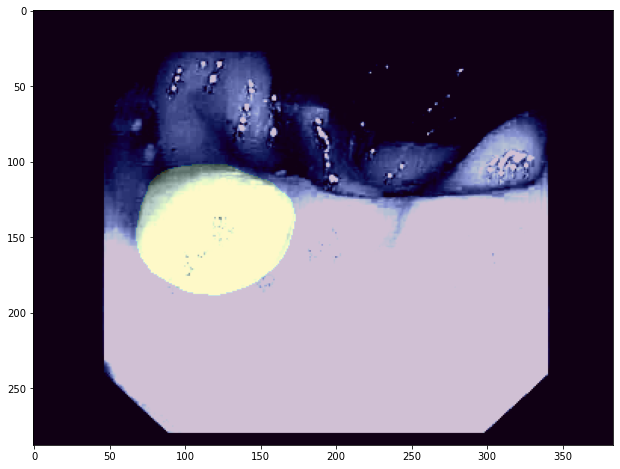

In [22]:
visualize(**train_dataset[2])

In [23]:
class PolypSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive polyp images must be greater than zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)
        
    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative
    
SAMPLER = PolypSampler(TRAIN_DF, positive_perc=1)

In [24]:
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=4, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(test_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
images, masks = next(iter(train_dataloader))['image'], next(iter(train_dataloader))['mask']
images.shape, masks.shape

In [ ]:
img_grid = torchvision.utils.make_grid(images[:9], nrow=3, normalize=True)
matplotlib_imshow(img_grid)